# Citi Bike Trips Data


This data has been processed to remove trips that are taken by staff as they service and inspect the system, trips that are taken to/from any of our “test” stations (which we were using more in June and July 2013), and any trips that were below 60 seconds in length (potentially false starts or users trying to re-dock a bike to ensure it's secure).


In [1]:
import numpy as np
import pandas as pd
import time, datetime
import matplotlib.pyplot as plt
import sqlalchemy as db
from sklearn.cluster import KMeans, Birch, SpectralBiclustering, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn import preprocessing

In [3]:
nyccb_reader = pd.read_csv('data/2019-citibike-tripdata.csv',
                             chunksize=100000,low_memory=False) 

In [4]:
nyccb_chunk = next(nyccb_reader)
nyc_cols = nyccb_chunk.columns
nyccb_chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
tripduration               100000 non-null int64
starttime                  100000 non-null object
stoptime                   100000 non-null object
start station id           100000 non-null float64
start station name         100000 non-null object
start station latitude     100000 non-null float64
start station longitude    100000 non-null float64
end station id             100000 non-null float64
end station name           100000 non-null object
end station latitude       100000 non-null float64
end station longitude      100000 non-null float64
bikeid                     100000 non-null int64
usertype                   100000 non-null object
birth year                 100000 non-null int64
gender                     100000 non-null int64
dtypes: float64(6), int64(4), object(5)
memory usage: 11.4+ MB


In [5]:
nyccb_chunk.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,320,2019-01-01 00:01:47.4010,2019-01-01 00:07:07.5810,3160.0,Central Park West & W 76 St,40.778968,-73.973747,3283.0,W 89 St & Columbus Ave,40.788221,-73.970416,15839,Subscriber,1971,1
1,316,2019-01-01 00:04:43.7360,2019-01-01 00:10:00.6080,519.0,Pershing Square North,40.751873,-73.977706,518.0,E 39 St & 2 Ave,40.747804,-73.973442,32723,Subscriber,1964,1
2,591,2019-01-01 00:06:03.9970,2019-01-01 00:15:55.4380,3171.0,Amsterdam Ave & W 82 St,40.785247,-73.976673,3154.0,E 77 St & 3 Ave,40.773142,-73.958562,27451,Subscriber,1987,1
3,2719,2019-01-01 00:07:03.5450,2019-01-01 00:52:22.6500,504.0,1 Ave & E 16 St,40.732219,-73.981656,3709.0,W 15 St & 6 Ave,40.738046,-73.996430,21579,Subscriber,1990,1
4,303,2019-01-01 00:07:35.9450,2019-01-01 00:12:39.5020,229.0,Great Jones St,40.727434,-73.993790,503.0,E 20 St & Park Ave,40.738274,-73.987520,35379,Subscriber,1979,1


### Initialize SQL engine

In [2]:
## Create database engine
sqlite_file = 'data/nyccb.sqlite'
engine = db.create_engine('sqlite:///' + sqlite_file)

In [7]:
## Fill in dataframe
nyccb_chunk.to_sql('cb',engine,if_exists='replace')
for nyccb_chunk in nyccb_reader:
    nyccb_chunk.to_sql('cb',engine,if_exists='append')

In [4]:
#count of bike stations
query = """select distinct [start station name] from cb"""
station_count = pd.read_sql_query(query, engine).count()
station_count

start station name    938
dtype: int64

In [3]:
station_list = pd.read_sql_query('SELECT DISTINCT [start station name], '
                                 '[start station id], '
                                 '[start station latitude], '
                                 '[start station longitude] '
                                 'FROM cb ', engine)                               
station_list

,start station name,start station id,start station latitude,start station longitude
0,Central Park West & W 76 St,3160.0,40.778968,-73.973747
1,Pershing Square North,519.0,40.751873,-73.977706
2,Amsterdam Ave & W 82 St,3171.0,40.785247,-73.976673
3,1 Ave & E 16 St,504.0,40.732219,-73.981656
4,Great Jones St,229.0,40.727434,-73.993790
...,...,...,...,...
1051,E 91 St & 2 Ave,3305.0,40.782000,-73.950000
1052,1 Ave & E 62 St,3142.0,40.761000,-73.962000
1053,Meserole Ave & Manhattan Ave,3110.0,40.728000,-73.953000
1054,Morgan Ave & Maspeth Ave,3854.0,40.716000,-73.935000


In [4]:
station_list = station_list.rename(columns={'start station name':'Name', 
                                            'start station id':'ID',
                                            'start station latitude': 'LAT',
                                            'start station longitude': 'LON'})
station_list = station_list.dropna()
station_list = station_list.drop_duplicates(subset='Name', keep='first')
#station_list.to_csv('data/station_list.csv')
station_list
#station_list[station_list['Name'] == '1 Ave & E 16 St']

,Name,ID,LAT,LON
0,Central Park West & W 76 St,3160.0,40.778968,-73.973747
1,Pershing Square North,519.0,40.751873,-73.977706
2,Amsterdam Ave & W 82 St,3171.0,40.785247,-73.976673
3,1 Ave & E 16 St,504.0,40.732219,-73.981656
4,Great Jones St,229.0,40.727434,-73.993790
...,...,...,...,...
1007,W Broadway & W Houston St,3740.0,40.726378,-74.000472
1015,Centre St & Seneca Ave,3884.0,40.699690,-73.902200
1016,Greene Ave & Grandview Ave,3910.0,40.709697,-73.907856
1026,Madison St & Woodward Ave,3909.0,40.704080,-73.904080


In [ ]:
#visualization of stations


In [6]:
#count of bike in operation
query = """select distinct [bikeid] from cb"""
bike_count = pd.read_sql_query(query, engine).count()
bike_count

bikeid    19571
dtype: int64

In [7]:
#number of total trips
total_trips = pd.read_sql_query("select [starttime] from cb",engine).count()
total_trips

starttime    20551697
dtype: int64

In [9]:
#average annual ridership per bicycle
total_trips.iloc[0] / bike_count.iloc[0]

1050.1097031321854

In [10]:
#average daily ridership per bicycle
total_trips.iloc[0] / bike_count.iloc[0] / 365

2.8770128852936585

In [11]:
#average riding duration
duration = pd.read_sql_query("select [tripduration] from cb",engine)
duration.sum()[0] / total_trips.iloc[0] / 60

16.304091616700397

In [3]:
group_cb_month = pd.read_sql_query('SELECT [starttime], strftime(\'%m\', starttime) AS month, '
                       'COUNT(*) as `Number of Trips` '
                       'FROM cb '
                       'GROUP BY month '
                       'ORDER BY month ', engine)
group_cb_month

,starttime,month,Number of Trips
0,2019-01-01 00:01:47.4010,01,967287
1,2019-02-01 00:00:06.2570,02,943744
2,2019-03-01 00:00:16.0970,03,1327960
3,2019-04-01 00:00:14.7410,04,1766094
4,2019-05-01 00:00:01.9010,05,1924563
5,2019-06-01 00:00:01.5000,06,2125370
6,2019-07-01 00:00:00.1320,07,2181064
7,2019-08-01 00:00:01.4680,08,2344224
8,2019-09-01 00:00:01.9580,09,2444900
9,2019-10-01 00:00:05.6180,10,2092573


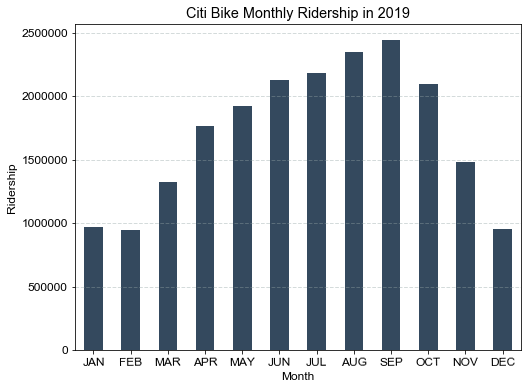

In [28]:
plt.rc('font', family='arial', size=12)
group_cb_month.plot(kind='bar',figsize=(8,6),color='#34495e',legend=False, rot=1)
plt.xlabel('Month')
plt.ylabel('Ridership')
plt.title('Citi Bike Monthly Ridership in 2019')
plt.xticks(np.arange(0,12,1), 
           ('JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC') )
plt.grid(color='#95a5a6',linestyle='--', linewidth=1 ,axis='y',alpha=0.4)
plt.show()

In [43]:
group_cb_gender = pd.read_sql_query('SELECT '
                       'COUNT(*) as `Number of Trips` '
                       'FROM cb '
                       'GROUP BY gender ', engine)
group_cb_gender

,Number of Trips
0,1560308
1,14052393
2,4938996


In [55]:
group_cb_gender['index'] = ['Unspecified','Male','Female']
group_cb_gender = group_cb_gender.set_index('index')

C:\Users\Ivan-Laptop\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  after removing the cwd from sys.path.


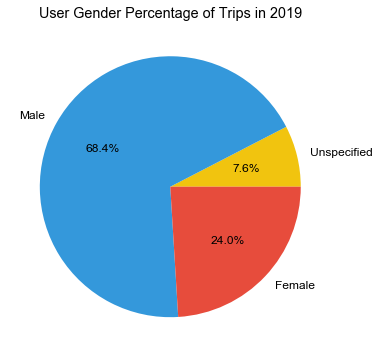

In [148]:
plt.figure(figsize=(8,6))
plt.rc('font', family='arial', size=12)
my_colors = ['#f1c40f','#3498db','#e74c3c']
plt.pie(group_cb_gender,labels=['Unspecified','Male','Female'],autopct='%1.1f%%',colors=my_colors)
plt.title('User Gender Percentage of Trips in 2019')
plt.show()

In [82]:
cb_age_18l = pd.read_sql_query('SELECT '
                       'COUNT(*) as `Number of Trips` '
                       'FROM cb '
                       'WHERE [birth year] > 2001 ', engine)
cb_age_1830 = pd.read_sql_query('SELECT '
                       'COUNT(*) as `Number of Trips` '
                       'FROM cb '
                       'WHERE [birth year] <= 2001 AND [birth year] > 1989', engine)
cb_age_3050 = pd.read_sql_query('SELECT '
                       'COUNT(*) as `Number of Trips` '
                       'FROM cb '
                       'WHERE [birth year] <= 1989 AND [birth year] > 1969', engine)
cb_age_50h = pd.read_sql_query('SELECT '
                       'COUNT(*) as `Number of Trips` '
                       'FROM cb '
                       'WHERE [birth year] <= 1969', engine)
group_cb_age = pd.concat([cb_age_18l,cb_age_1830,cb_age_3050,cb_age_50h])
group_cb_age['index'] = ['<18','18-30','30-50','>50']
group_cb_age = group_cb_age.set_index('index')
group_cb_age

,Number of Trips
index,
<18,37380
18-30,5550786
30-50,9847327
>50,5116204


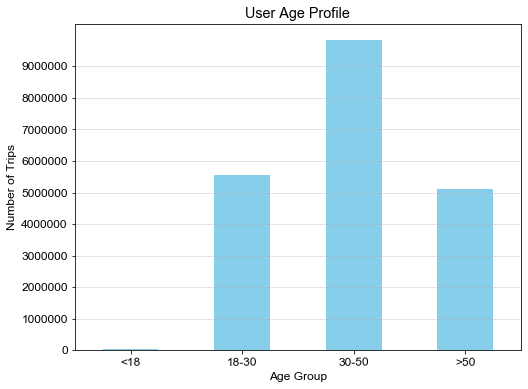

In [131]:
plt.rc('font', family='arial', size=12)
group_cb_age.plot(kind='bar',rot=1,legend=False,figsize=(8,6),color='skyblue')
plt.title('User Age Profile')
plt.xlabel('Age Group')
plt.ylabel('Number of Trips')
plt.grid(axis="y",linestyle='--',linewidth=0.5)
plt.yticks(np.arange(0,10000000,1000000))
plt.show()

In [134]:
group_cb_usertype = pd.read_sql_query('SELECT usertype, '
                       'COUNT(*) as `Number of Trips` '
                       'FROM cb '
                       'GROUP BY [usertype] ', engine)
group_cb_usertype

,usertype,Number of Trips
0,Customer,2872176
1,Subscriber,17679521


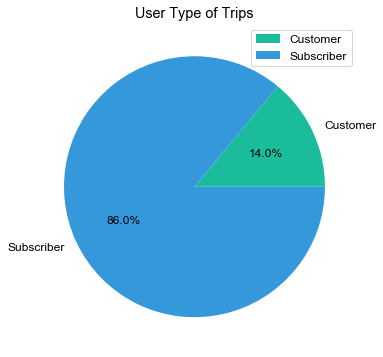

In [149]:
plt.figure(figsize=(8,6))
plt.rc('font', family='arial', size=12)
my_colors = ['#1abc9c','#3498db']
plt.pie(group_cb_usertype['Number of Trips'],
        labels=group_cb_usertype['usertype'],autopct='%1.1f%%',colors=my_colors)
plt.legend(loc='best')
plt.title('User Type of Trips')
plt.show()

In [38]:
cb_week_avg = pd.read_sql_query('SELECT strftime(\'%w\', starttime) AS weekday, '
                       'COUNT(*)/52.14 as `Number of Trips` '
                       'FROM cb '
                       #'WHERE [starttime] >= "2019-09-01" '
                       #'AND [starttime] < "2019-09-29" '
                       'GROUP BY weekday '
                       'ORDER BY weekday ', engine)
cb_week_avg

,weekday,Number of Trips
0,0,45849.578059
1,1,56043.459916
2,2,60566.762562
3,3,60351.074031
4,4,57561.181435
5,5,59797.161488
6,6,53994.514768


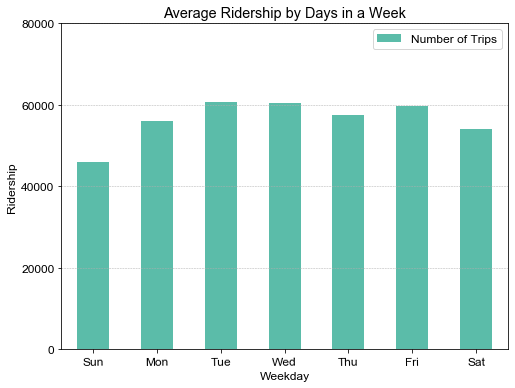

In [65]:
plt.rc('font', family='arial', size=12)
cb_week_sample.plot(kind='bar',alpha=0.7,color='#16a085',rot=1,figsize=(8,6))
plt.title('Average Ridership by Days in a Week')
plt.xlabel('Weekday')
plt.ylabel('Ridership')
plt.yticks(np.arange(0,100000,20000))
plt.xticks(np.arange(0,7,1),('Sun','Mon','Tue','Wed','Thu','Fri','Sat'))
plt.grid(axis="y",linestyle='--',linewidth=0.5)
plt.show()

In [67]:
cb_weekday = pd.read_sql_query('SELECT strftime(\'%H\', starttime) AS hour, '
                       'COUNT(*)/261 as `Number of Trips` '
                       'FROM cb '
                       'WHERE strftime(\'%w\', starttime) >= "1" '
                       'AND strftime(\'%w\', starttime) < "6" '
                       'GROUP BY hour '
                       'ORDER BY hour ', engine)
cb_weekday

,hour,Number of Trips
0,00,397
1,01,200
2,02,115
3,03,74
4,04,116
5,05,485
6,06,1578
7,07,3306
8,08,5705
9,09,4147


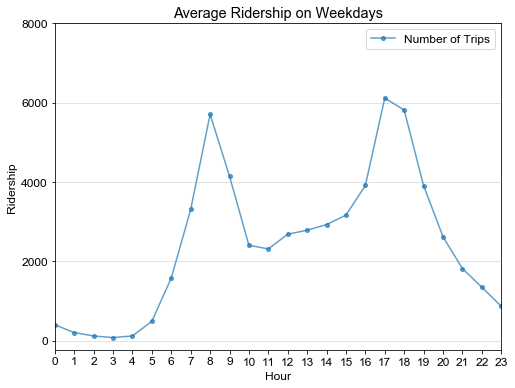

In [69]:
plt.rc('font', family='arial', size=12)
cb_weekday.plot(kind='line',alpha=0.7,rot=1,figsize=(8,6),marker='o',markersize=4)
plt.title('Average Ridership on Weekdays')
plt.xlabel('Hour')
plt.ylabel('Ridership')
plt.yticks(np.arange(0,10000,2000))
plt.xticks(np.arange(0,24,1))
plt.grid(axis="y",linestyle='--',linewidth=0.5)
plt.show()

In [80]:
cb_duration_5l = pd.read_sql_query('SELECT '
                       'COUNT(*) as `Number of Trips` '
                       'FROM cb '
                       'WHERE [tripduration] < 300 ', engine)
cb_duration_510 = pd.read_sql_query('SELECT '
                       'COUNT(*) as `Number of Trips` '
                       'FROM cb '
                       'WHERE [tripduration] >= 300 AND [tripduration] < 600', engine)
cb_duration_1020 = pd.read_sql_query('SELECT '
                       'COUNT(*) as `Number of Trips` '
                       'FROM cb '
                       'WHERE [tripduration] >= 600 AND [tripduration] < 1200', engine)
cb_duration_2030 = pd.read_sql_query('SELECT '
                       'COUNT(*) as `Number of Trips` '
                       'FROM cb '
                       'WHERE [tripduration] >= 1200 AND [tripduration] < 1800', engine)
cb_duration_30h = pd.read_sql_query('SELECT '
                       'COUNT(*) as `Number of Trips` '
                       'FROM cb '
                       'WHERE [tripduration] >= 1800', engine)
group_cb_duration = pd.concat([cb_duration_5l,
                               cb_duration_510,
                               cb_duration_1020,
                               cb_duration_2030,
                               cb_duration_30h])
group_cb_duration['index'] = ['<5 min','5-10 min','10-20 min','20-30 min','>30 min']
group_cb_duration = group_cb_duration.set_index('index')
group_cb_duration

,Number of Trips
index,
<5 min,3652433
5-10 min,6364411
10-20 min,6209032
20-30 min,2651349
>30 min,1674472


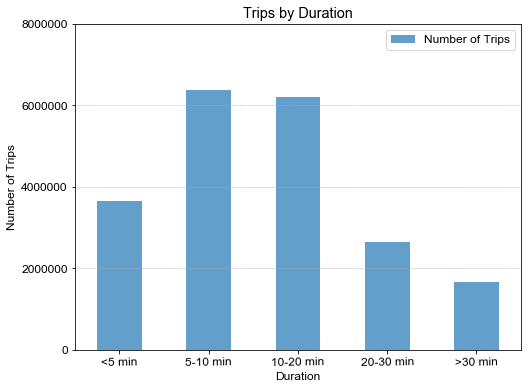

In [82]:
plt.rc('font', family='arial', size=12)
group_cb_duration.plot(kind='bar',alpha=0.7,rot=1,figsize=(8,6))
plt.title('Trips by Duration')
plt.xlabel('Duration')
plt.ylabel('Number of Trips')
plt.yticks(np.arange(0,10000000,2000000))
plt.grid(axis="y",linestyle='--',linewidth=0.5)
plt.show()

In [53]:
cb_toporigin = pd.read_sql_query('SELECT [start station name], '
                                 'COUNT(*) as `Number of Starts` '
                                 'FROM cb '
                                 'GROUP BY [start station name] '
                                 'ORDER BY [Number of Starts] DESC', engine)
cb_toporigin

,start station name,Number of Starts
0,Pershing Square North,156575
1,E 17 St & Broadway,121781
2,8 Ave & W 31 St,119958
3,Broadway & E 22 St,113138
4,Broadway & E 14 St,113012
...,...,...
934,Fairview Ave & Linden St,8
935,NYCBS DEPOT - DELANCEY,6
936,Madison St & Woodward Ave,6
937,58th St Depot,6


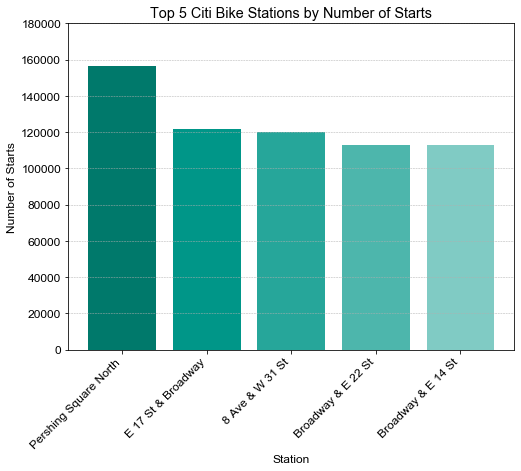

In [62]:
plt.figure(figsize=(8,6))
plt.rc('font', family='arial', size=12)
plt.bar(cb_toporigin.head()['start station name'],
        height=cb_toporigin.head()['Number of Starts'],
        color=['#00796B','#009688','#26A69A','#4DB6AC','#80CBC4'])
plt.title('Top 5 Citi Bike Stations by Number of Starts')
plt.xlabel('Station')
plt.ylabel('Number of Starts')
plt.yticks(np.arange(0,200000,20000))
plt.xticks(np.arange(0,5,1),cb_toporigin.head()['start station name'],rotation=45,ha='right')
plt.grid(axis="y",linestyle='--',linewidth=0.5)
plt.show()

In [57]:
cb_toptrip = pd.read_sql_query('SELECT [start station name], [end station name], '
                                 'COUNT(*) as `Number of Trips` '
                                 'FROM cb '
                                 'GROUP BY [start station name], [end station name] '
                                 'ORDER BY [Number of Trips] DESC', engine)
cb_toptrip

,start station name,end station name,Number of Trips
0,E 7 St & Avenue A,Cooper Square & Astor Pl,8426
1,Central Park S & 6 Ave,Central Park S & 6 Ave,6778
2,Central Park S & 6 Ave,5 Ave & E 88 St,6092
3,North Moore St & Greenwich St,Vesey Pl & River Terrace,5366
4,West Drive & Prospect Park West,West Drive & Prospect Park West,5364
...,...,...,...
396046,Yankee Ferry Terminal,Old Slip & Front St,1
396047,Yankee Ferry Terminal,Van Brunt St & Wolcott St,1
396048,Yankee Ferry Terminal,W 45 St & 8 Ave,1
396049,Yankee Ferry Terminal,Water - Whitehall Plaza,1


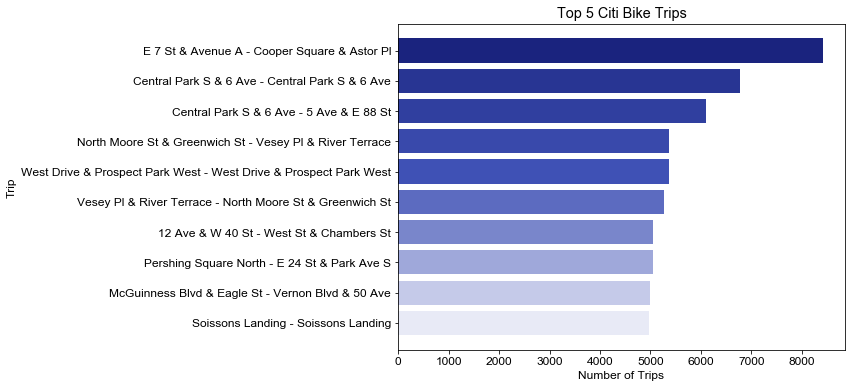

In [183]:
ylab=[]
for _ in range(10):
    tmp = cb_toptrip['start station name'][_] + ' - ' + cb_toptrip['end station name'][_]
    ylab.append(tmp)

plt.figure(figsize=(8,6))
plt.rc('font', family='arial', size=12)
plt.barh(np.arange(0,10,1),
         cb_toptrip.head(10)['Number of Trips'],
         color=['#1A237E','#283593','#303F9F','#3949AB','#3F51B5',
                '#5C6BC0','#7986CB','#9FA8DA','#C5CAE9','#E8EAF6'])
plt.title('Top 5 Citi Bike Trips') 
plt.ylabel('Trip')
plt.xlabel('Number of Trips')
plt.gca().invert_yaxis()
plt.yticks(np.arange(0,10,1),ylab,rotation=0,ha='right')
plt.show()

In [146]:
cb_tripsample = pd.read_sql_query('SELECT [start station name], [end station name], '
                                  '[tripduration]/60 AS `Minutes of Use`'
                                  'FROM cb '
                                  'WHERE [start station name] = "Central Park S & 6 Ave" '
                                  'AND [end station name] = "Central Park S & 6 Ave" '
                                  'ORDER BY [Minutes of Use] DESC', engine)
cb_tripsample

,start station name,end station name,Minutes of Use
0,Central Park S & 6 Ave,Central Park S & 6 Ave,2724
1,Central Park S & 6 Ave,Central Park S & 6 Ave,1075
2,Central Park S & 6 Ave,Central Park S & 6 Ave,847
3,Central Park S & 6 Ave,Central Park S & 6 Ave,804
4,Central Park S & 6 Ave,Central Park S & 6 Ave,673
...,...,...,...
6773,Central Park S & 6 Ave,Central Park S & 6 Ave,1
6774,Central Park S & 6 Ave,Central Park S & 6 Ave,1
6775,Central Park S & 6 Ave,Central Park S & 6 Ave,1
6776,Central Park S & 6 Ave,Central Park S & 6 Ave,1


<Figure size 576x432 with 0 Axes>

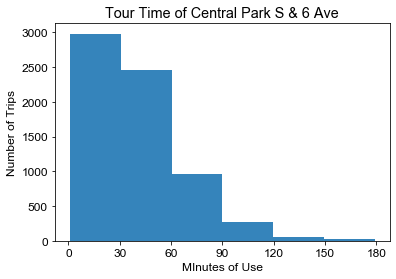

In [182]:
plt.figure(figsize=(8,6))
plt.rc('font', family='arial', size=12)
cb_tripsample[cb_tripsample['Minutes of Use']<=180].hist(bins=6,grid=False,alpha=0.9)
plt.title('Tour Time of Central Park S & 6 Ave')
plt.ylabel('Number of Trips')
plt.xlabel('MInutes of Use')
plt.xticks(np.arange(0,210,30))
plt.show()

In [4]:
cb_popbike = pd.read_sql_query('SELECT [bikeid], '
                                 'COUNT(*) as `Number of Trips` '
                                 'FROM cb '
                                 'GROUP BY [bikeid] '
                                 'ORDER BY [Number of Trips] DESC', engine)
cb_popbike

,bikeid,Number of Trips
0,35194,3150
1,34332,3101
2,34969,3097
3,34187,3093
4,34295,3064
...,...,...
19566,29230,1
19567,29222,1
19568,26281,1
19569,26181,1


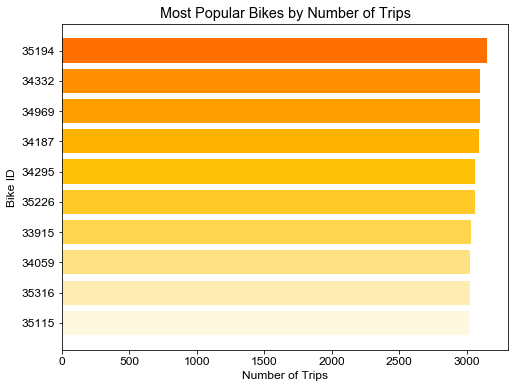

In [5]:
plt.figure(figsize=(8,6))
plt.rc('font', family='arial', size=12)
plt.barh(np.arange(0,10,1),
         cb_popbike.head(10)['Number of Trips'],
         color=['#FF6F00','#FF8F00','#FFA000','#FFB300','#FFC107',
                '#FFCA28','#FFD54F','#FFE082','#FFECB3','#FFF8E1'])
plt.title('Most Popular Bikes by Number of Trips') 
plt.ylabel('Bike ID')
plt.xlabel('Number of Trips')
plt.gca().invert_yaxis()
plt.yticks(np.arange(0,10,1),cb_popbike['bikeid'],rotation=0,ha='right')
plt.show()

In [11]:
cb_topbike_trips = pd.read_sql_query('SELECT [start station name], [end station name], '
                               'COUNT(*) as `Number of Trips` '
                               'FROM cb '
                               'WHERE [bikeid] = 35194 '
                               'GROUP BY [start station name], [end station name] '
                               'ORDER BY [Number of Trips] DESC', engine)
cb_topbike_trips

,start station name,end station name,Number of Trips
0,University Pl & E 8 St,University Pl & E 8 St,4
1,Broadway & 12 St,31 St & Broadway,3
2,Broadway & Roebling St,S 4 St & Wythe Ave,3
3,Broadway & W 60 St,W 59 St & 10 Ave,3
4,Central Park S & 6 Ave,Central Park West & W 72 St,3
...,...,...,...
3004,Wyckoff St & 3 Ave,DeKalb Ave & Vanderbilt Ave,1
3005,Wythe Ave & Metropolitan Ave,Division Av & Hooper St,1
3006,Wythe Ave & Metropolitan Ave,Franklin St & Dupont St,1
3007,Wythe Ave & Metropolitan Ave,N 6 St & Bedford Ave,1


In [3]:
cb_station_starts = pd.read_sql_query('SELECT [start station name], '
                                     '[start station id], '
                                     '[start station latitude], '
                                     '[start station longitude], '
                                     'COUNT(*) AS `Trips` '
                                     'FROM cb '
                                     'WHERE [starttime] >= "2019-09-23 07:00" '
                                     'AND [starttime] < "2019-09-23 10:00" '
                                     'GROUP BY [start station name] ', engine)
cb_station_starts

,start station name,start station id,start station latitude,start station longitude,Trips
0,1 Ave & E 110 St,3496.0,40.792327,-73.938300,16
1,1 Ave & E 16 St,504.0,40.732219,-73.981656,101
2,1 Ave & E 18 St,2003.0,40.733812,-73.980544,57
3,1 Ave & E 30 St,536.0,40.741444,-73.975361,47
4,1 Ave & E 62 St,3142.0,40.761227,-73.960940,41
...,...,...,...,...,...
749,Wolcott St & Dwight St,3340.0,40.675327,-74.010070,3
750,Wyckoff Av & Jefferson St,3763.0,40.707165,-73.923711,3
751,Wyckoff St & 3 Ave,3413.0,40.682755,-73.982586,8
752,Wyckoff St & Bond St,3720.0,40.684617,-73.987213,5


In [5]:
cb_station_starts = cb_station_starts.dropna()
cb_station_starts.to_csv('data/station_starts_0923AM.csv')

In [6]:
cb_station_ends = pd.read_sql_query('SELECT [end station name], '
                                     '[end station id], '
                                     '[end station latitude], '
                                     '[end station longitude], '
                                     'COUNT(*) AS `Trips` '
                                     'FROM cb '
                                     'WHERE [starttime] >= "2019-09-23 07:00" '
                                     'AND [starttime] < "2019-09-23 10:00" '
                                     'GROUP BY [end station name] ', engine)
cb_station_ends

,end station name,end station id,end station latitude,end station longitude,Trips
0,1 Ave & E 110 St,3496.0,40.792327,-73.938300,6
1,1 Ave & E 16 St,504.0,40.732219,-73.981656,59
2,1 Ave & E 18 St,2003.0,40.733812,-73.980544,16
3,1 Ave & E 30 St,536.0,40.741444,-73.975361,45
4,1 Ave & E 62 St,3142.0,40.761227,-73.960940,26
...,...,...,...,...,...
732,Willoughby Ave & Walworth St,373.0,40.693317,-73.953820,4
733,Willoughby St & Fleet St,239.0,40.691966,-73.981302,34
734,Wyckoff St & 3 Ave,3413.0,40.682755,-73.982586,3
735,Wyckoff St & Bond St,3720.0,40.684617,-73.987213,1


In [7]:
cb_station_ends = cb_station_ends.dropna()
cb_station_ends.to_csv('data/station_ends_0923AM.csv')

## About Calculating Trip Distances

- No reliable way to calculate bike route since we can’t know what route a rider took without GPS data from each bike.

- Could use Google maps and use lat, long coordinates to find bike route distance. However, this would require more than the daily limit on API calls. Use the geopy.distance package which uses Vincenty distance uses more accurate ellipsoidal models. This is more accurate than Haversine formula, but doesn’t matter much for our purposes since the curvature of the earth has a negligible effect on the distance for bike trips in NYC.

# Cluster Analysis

Obtain average station starts & ends in the AM peak and PM peak.

In [ ]:
AM_station_O = pd.read_sql_query('SELECT [start station name] AS Station, '
                               '[start station id] AS ID, '
                               'COUNT (*) / 261 AS `Number of Starts` '
                               'FROM cb '
                               'WHERE strftime(\'%w\', starttime) >= "1" '
                               'AND strftime(\'%w\', starttime) < "6" '
                               'AND strftime(\'%H\', starttime) >= "07" '
                               'AND strftime(\'%H\', starttime) < "10" '
                               'GROUP BY [start station name]', engine)

AM_station_D = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 261 AS `Number of Ends` '
                               'FROM cb '
                               'WHERE strftime(\'%w\', stoptime) >= "1" '
                               'AND strftime(\'%w\', stoptime) < "6" '
                               'AND strftime(\'%H\', stoptime) >= "07" '
                               'AND strftime(\'%H\', stoptime) < "10" '
                               'GROUP BY [end station name]', engine)

In [109]:
AM_station_OD = pd.merge(AM_station_O, AM_station_D,on=['Station','ID'])
AM_station_OD['Net'] = AM_station_OD['Number of Ends'] - AM_station_OD['Number of Starts']
AM_station_OD = AM_station_OD.dropna()
AM_station_OD

,Station,ID,Number of Starts,Number of Ends,Net
1,1 Ave & E 110 St,3496.0,11,5,-6
2,1 Ave & E 16 St,504.0,71,32,-39
3,1 Ave & E 18 St,2003.0,50,19,-31
4,1 Ave & E 30 St,536.0,38,42,4
5,1 Ave & E 44 St,455.0,20,58,38
...,...,...,...,...,...
917,Wyckoff St & 3 Ave,3413.0,8,2,-6
918,Wyckoff St & Bond St,3720.0,2,0,-2
919,Wyckoff St & Nevins St,3911.0,0,0,0
920,Wythe Ave & Metropolitan Ave,2002.0,23,19,-4


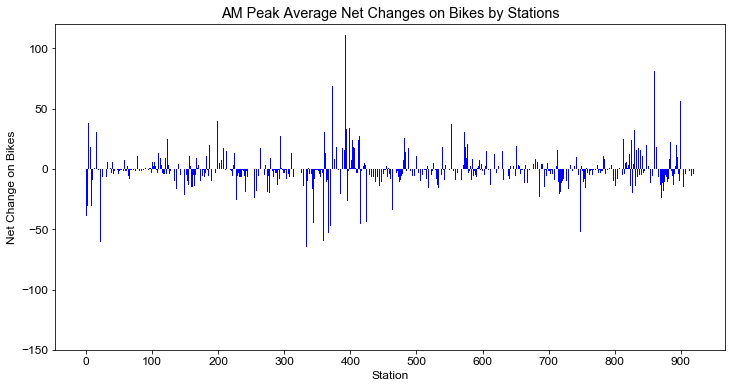

In [110]:
plt.figure(figsize=(12,6))
plt.rc('font', family='arial', size=12)
plt.bar(x=np.arange(AM_station_OD.shape[0]),height=AM_station_OD['Net'],color='blue')
plt.title('AM Peak Average Net Changes on Bikes by Stations') 
plt.ylabel('Net Change on Bikes')
plt.xlabel('Station')
plt.yticks(np.arange(-150,150,50))
plt.xticks(np.arange(0,AM_station_OD.shape[0],100))
plt.show()

In [ ]:
PM_station_O = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 261 AS `Number of Starts` '
                               'FROM cb '
                               'WHERE strftime(\'%w\', starttime) >= "1" '
                               'AND strftime(\'%w\', starttime) < "6" '
                               'AND strftime(\'%H\', starttime) >= "16" '
                               'AND strftime(\'%H\', starttime) < "19" '
                               'GROUP BY [start station name]', engine)

PM_station_D = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 261 AS `Number of Ends` '
                               'FROM cb '
                               'WHERE strftime(\'%w\', stoptime) >= "1" '
                               'AND strftime(\'%w\', stoptime) < "6" '
                               'AND strftime(\'%H\', stoptime) >= "16" '
                               'AND strftime(\'%H\', stoptime) < "19" '
                               'GROUP BY [end station name]', engine)

In [101]:
PM_station_OD = pd.merge(PM_station_O, PM_station_D,on=['Station','ID'])
PM_station_OD['Net'] = PM_station_OD['Number of Ends'] - PM_station_OD['Number of Starts']
PM_station_OD = PM_station_OD.dropna()
PM_station_OD

,Station,ID,Number of Starts,Number of Ends,Net
1,1 Ave & E 110 St,3496.0,8,10,2
2,1 Ave & E 16 St,504.0,47,71,24
3,1 Ave & E 18 St,2003.0,32,59,27
4,1 Ave & E 30 St,536.0,29,20,-9
5,1 Ave & E 44 St,455.0,53,17,-36
...,...,...,...,...,...
928,Wyckoff St & 3 Ave,3413.0,4,8,4
929,Wyckoff St & Bond St,3720.0,1,3,2
930,Wyckoff St & Nevins St,3911.0,0,0,0
931,Wythe Ave & Metropolitan Ave,2002.0,22,25,3


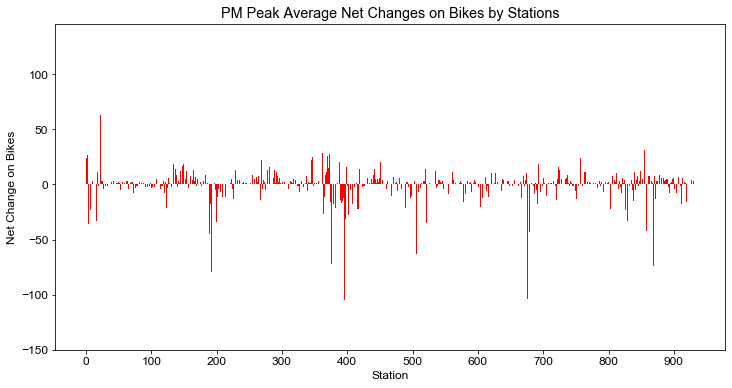

In [106]:
plt.figure(figsize=(12,6))
plt.rc('font', family='arial', size=12)
plt.bar(x=np.arange(PM_station_OD.shape[0]),height=PM_station_OD['Net'],color='red')
plt.title('PM Peak Average Net Changes on Bikes by Stations') 
plt.ylabel('Net Change on Bikes')
plt.xlabel('Station')
plt.yticks(np.arange(-150,150,50))
plt.xticks(np.arange(0,PM_station_OD.shape[0],100))
plt.show()

## Clustering Data Extraction

Obtain average station starts & ends by hour.

In [71]:
O_01 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_01` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "00" '
                               'AND strftime(\'%H\', starttime) < "01" '
                               'GROUP BY [start station name]', engine)

D_01 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_01` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "00" '
                               'AND strftime(\'%H\', stoptime) < "01" '
                               'GROUP BY [end station name]', engine)
OD_01 = pd.merge(O_01, D_01, on=['Station','ID'], how='outer')
OD_01['Net_01'] = OD_01['D_01'] - OD_01['O_01']
OD_01 = OD_01.dropna()
OD_01

,Station,ID,O_01,D_01,Net_01
1,1 Ave & E 110 St,3496.0,0.0,0.0,0.0
2,1 Ave & E 16 St,504.0,2.0,3.0,1.0
3,1 Ave & E 18 St,2003.0,1.0,2.0,1.0
4,1 Ave & E 30 St,536.0,0.0,0.0,0.0
5,1 Ave & E 44 St,455.0,0.0,0.0,0.0
...,...,...,...,...,...
907,Wyckoff Av & Jefferson St,3763.0,0.0,0.0,0.0
908,Wyckoff Av & Stanhope St,3780.0,0.0,0.0,0.0
909,Wyckoff St & 3 Ave,3413.0,0.0,0.0,0.0
910,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0


In [72]:
O_12 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_12` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "01" '
                               'AND strftime(\'%H\', starttime) < "02" '
                               'GROUP BY [start station name]', engine)

D_12 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_12` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "01" '
                               'AND strftime(\'%H\', stoptime) < "02" '
                               'GROUP BY [end station name]', engine)
OD_12 = pd.merge(O_12, D_12, on=['Station','ID'], how='outer')
OD_12['Net_12'] = OD_12['D_12'] - OD_12['O_12']
OD_12 = OD_12.dropna()
OD_12

,Station,ID,O_12,D_12,Net_12
1,1 Ave & E 110 St,3496.0,0.0,0.0,0.0
2,1 Ave & E 16 St,504.0,1.0,1.0,0.0
3,1 Ave & E 18 St,2003.0,0.0,1.0,1.0
4,1 Ave & E 30 St,536.0,0.0,0.0,0.0
5,1 Ave & E 44 St,455.0,0.0,0.0,0.0
...,...,...,...,...,...
901,Wyckoff Av & Jefferson St,3763.0,0.0,0.0,0.0
902,Wyckoff Av & Stanhope St,3780.0,0.0,0.0,0.0
903,Wyckoff St & 3 Ave,3413.0,0.0,0.0,0.0
904,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0


In [73]:
O_23 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_23` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "02" '
                               'AND strftime(\'%H\', starttime) < "03" '
                               'GROUP BY [start station name]', engine)

D_23 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_23` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "02" '
                               'AND strftime(\'%H\', stoptime) < "03" '
                               'GROUP BY [end station name]', engine)
OD_23 = pd.merge(O_23, D_23, on=['Station','ID'], how='outer')
OD_23['Net_23'] = OD_23['D_23'] - OD_23['O_23']
OD_23 = OD_23.dropna()
OD_23

,Station,ID,O_23,D_23,Net_23
1,1 Ave & E 110 St,3496.0,0.0,0.0,0.0
2,1 Ave & E 16 St,504.0,1.0,1.0,0.0
3,1 Ave & E 18 St,2003.0,0.0,0.0,0.0
4,1 Ave & E 30 St,536.0,0.0,0.0,0.0
5,1 Ave & E 44 St,455.0,0.0,0.0,0.0
...,...,...,...,...,...
894,Wyckoff Av & Jefferson St,3763.0,0.0,0.0,0.0
895,Wyckoff Av & Stanhope St,3780.0,0.0,0.0,0.0
896,Wyckoff St & 3 Ave,3413.0,0.0,0.0,0.0
897,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0


In [74]:
O_34 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_34` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "03" '
                               'AND strftime(\'%H\', starttime) < "04" '
                               'GROUP BY [start station name]', engine)

D_34 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_34` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "03" '
                               'AND strftime(\'%H\', stoptime) < "04" '
                               'GROUP BY [end station name]', engine)
OD_34 = pd.merge(O_34, D_34, on=['Station','ID'], how='outer')
OD_34['Net_34'] = OD_34['D_34'] - OD_34['O_34']
OD_34 = OD_34.dropna()
OD_34

,Station,ID,O_34,D_34,Net_34
1,1 Ave & E 110 St,3496.0,0.0,0.0,0.0
2,1 Ave & E 16 St,504.0,0.0,0.0,0.0
3,1 Ave & E 18 St,2003.0,0.0,0.0,0.0
4,1 Ave & E 30 St,536.0,0.0,0.0,0.0
5,1 Ave & E 44 St,455.0,0.0,0.0,0.0
...,...,...,...,...,...
892,Wyckoff Av & Jefferson St,3763.0,0.0,0.0,0.0
893,Wyckoff Av & Stanhope St,3780.0,0.0,0.0,0.0
894,Wyckoff St & 3 Ave,3413.0,0.0,0.0,0.0
895,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0


In [75]:
O_45 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_45` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "04" '
                               'AND strftime(\'%H\', starttime) < "05" '
                               'GROUP BY [start station name]', engine)

D_45 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_45` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "04" '
                               'AND strftime(\'%H\', stoptime) < "05" '
                               'GROUP BY [end station name]', engine)
OD_45 = pd.merge(O_45, D_45, on=['Station','ID'], how='outer')
OD_45['Net_45'] = OD_45['D_45'] - OD_45['O_45']
OD_45 = OD_45.dropna()
OD_45

,Station,ID,O_45,D_45,Net_45
1,1 Ave & E 110 St,3496.0,0.0,0.0,0.0
2,1 Ave & E 16 St,504.0,1.0,0.0,-1.0
3,1 Ave & E 18 St,2003.0,0.0,0.0,0.0
4,1 Ave & E 30 St,536.0,0.0,1.0,1.0
5,1 Ave & E 44 St,455.0,0.0,0.0,0.0
...,...,...,...,...,...
883,Wyckoff Av & Jefferson St,3763.0,0.0,0.0,0.0
884,Wyckoff Av & Stanhope St,3780.0,0.0,0.0,0.0
885,Wyckoff St & 3 Ave,3413.0,0.0,0.0,0.0
886,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0


In [76]:
O_56 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_56` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "05" '
                               'AND strftime(\'%H\', starttime) < "06" '
                               'GROUP BY [start station name]', engine)

D_56 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_56` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "05" '
                               'AND strftime(\'%H\', stoptime) < "06" '
                               'GROUP BY [end station name]', engine)
OD_56 = pd.merge(O_56, D_56, on=['Station','ID'], how='outer')
OD_56['Net_56'] = OD_56['D_56'] - OD_56['O_56']
OD_56 = OD_56.dropna()
OD_56

,Station,ID,O_56,D_56,Net_56
1,1 Ave & E 110 St,3496.0,0.0,0.0,0.0
2,1 Ave & E 16 St,504.0,2.0,1.0,-1.0
3,1 Ave & E 18 St,2003.0,2.0,0.0,-2.0
4,1 Ave & E 30 St,536.0,0.0,2.0,2.0
5,1 Ave & E 44 St,455.0,0.0,0.0,0.0
...,...,...,...,...,...
885,Wyckoff Av & Jefferson St,3763.0,0.0,0.0,0.0
886,Wyckoff Av & Stanhope St,3780.0,0.0,0.0,0.0
887,Wyckoff St & 3 Ave,3413.0,0.0,0.0,0.0
888,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0


In [77]:
O_67 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_67` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "06" '
                               'AND strftime(\'%H\', starttime) < "07" '
                               'GROUP BY [start station name]', engine)

D_67 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_67` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "06" '
                               'AND strftime(\'%H\', stoptime) < "07" '
                               'GROUP BY [end station name]', engine)
OD_67 = pd.merge(O_67, D_67, on=['Station','ID'], how='outer')
OD_67['Net_67'] = OD_67['D_67'] - OD_67['O_67']
OD_67 = OD_67.dropna()
OD_67

,Station,ID,O_67,D_67,Net_67
1,1 Ave & E 110 St,3496.0,1.0,0.0,-1.0
2,1 Ave & E 16 St,504.0,9.0,4.0,-5.0
3,1 Ave & E 18 St,2003.0,7.0,2.0,-5.0
4,1 Ave & E 30 St,536.0,2.0,9.0,7.0
5,1 Ave & E 44 St,455.0,1.0,1.0,0.0
...,...,...,...,...,...
902,Wyckoff Av & Jefferson St,3763.0,0.0,0.0,0.0
903,Wyckoff Av & Stanhope St,3780.0,0.0,0.0,0.0
904,Wyckoff St & 3 Ave,3413.0,0.0,0.0,0.0
905,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0


In [78]:
O_78 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_78` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "07" '
                               'AND strftime(\'%H\', starttime) < "08" '
                               'GROUP BY [start station name]', engine)

D_78 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_78` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "07" '
                               'AND strftime(\'%H\', stoptime) < "08" '
                               'GROUP BY [end station name]', engine)
OD_78 = pd.merge(O_78, D_78, on=['Station','ID'], how='outer')
OD_78['Net_78'] = OD_78['D_78'] - OD_78['O_78']
OD_78 = OD_78.dropna()
OD_78

,Station,ID,O_78,D_78,Net_78
1,1 Ave & E 110 St,3496.0,3.0,1.0,-2.0
2,1 Ave & E 16 St,504.0,15.0,7.0,-8.0
3,1 Ave & E 18 St,2003.0,15.0,5.0,-10.0
4,1 Ave & E 30 St,536.0,6.0,11.0,5.0
5,1 Ave & E 44 St,455.0,2.0,4.0,2.0
...,...,...,...,...,...
914,Wyckoff Av & Stanhope St,3780.0,0.0,0.0,0.0
915,Wyckoff St & 3 Ave,3413.0,1.0,0.0,-1.0
916,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0
918,Wythe Ave & Metropolitan Ave,2002.0,5.0,2.0,-3.0


In [79]:
O_89 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_89` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "08" '
                               'AND strftime(\'%H\', starttime) < "09" '
                               'GROUP BY [start station name]', engine)

D_89 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_89` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "08" '
                               'AND strftime(\'%H\', stoptime) < "09" '
                               'GROUP BY [end station name]', engine)
OD_89 = pd.merge(O_89, D_89, on=['Station','ID'], how='outer')
OD_89['Net_89'] = OD_89['D_89'] - OD_89['O_89']
OD_89 = OD_89.dropna()
OD_89

,Station,ID,O_89,D_89,Net_89
1,1 Ave & E 110 St,3496.0,4.0,2.0,-2.0
2,1 Ave & E 16 St,504.0,25.0,10.0,-15.0
3,1 Ave & E 18 St,2003.0,17.0,6.0,-11.0
4,1 Ave & E 30 St,536.0,13.0,11.0,-2.0
5,1 Ave & E 44 St,455.0,7.0,19.0,12.0
...,...,...,...,...,...
918,Wyckoff Av & Stanhope St,3780.0,0.0,0.0,0.0
919,Wyckoff St & 3 Ave,3413.0,3.0,0.0,-3.0
920,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0
922,Wythe Ave & Metropolitan Ave,2002.0,7.0,5.0,-2.0


In [80]:
O_910 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_910` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "09" '
                               'AND strftime(\'%H\', starttime) < "10" '
                               'GROUP BY [start station name]', engine)

D_910 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_910` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "09" '
                               'AND strftime(\'%H\', stoptime) < "10" '
                               'GROUP BY [end station name]', engine)
OD_910 = pd.merge(O_910, D_910, on=['Station','ID'], how='outer')
OD_910['Net_910'] = OD_910['D_910'] - OD_910['O_910']
OD_910 = OD_910.dropna()
OD_910

,Station,ID,O_910,D_910,Net_910
1,1 Ave & E 110 St,3496.0,1.0,1.0,0.0
2,1 Ave & E 16 St,504.0,16.0,8.0,-8.0
3,1 Ave & E 18 St,2003.0,9.0,4.0,-5.0
4,1 Ave & E 30 St,536.0,10.0,10.0,0.0
5,1 Ave & E 44 St,455.0,6.0,18.0,12.0
...,...,...,...,...,...
923,Wyckoff St & 3 Ave,3413.0,2.0,1.0,-1.0
924,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0
925,Wyckoff St & Nevins St,3911.0,0.0,0.0,0.0
926,Wythe Ave & Metropolitan Ave,2002.0,6.0,8.0,2.0


In [81]:
O_1011 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_1011` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "10" '
                               'AND strftime(\'%H\', starttime) < "11" '
                               'GROUP BY [start station name]', engine)

D_1011 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_1011` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "10" '
                               'AND strftime(\'%H\', stoptime) < "11" '
                               'GROUP BY [end station name]', engine)
OD_1011 = pd.merge(O_1011, D_1011, on=['Station','ID'], how='outer')
OD_1011['Net_1011'] = OD_1011['D_1011'] - OD_1011['O_1011']
OD_1011 = OD_1011.dropna()
OD_1011

,Station,ID,O_1011,D_1011,Net_1011
1,1 Ave & E 110 St,3496.0,1.0,1.0,0.0
2,1 Ave & E 16 St,504.0,10.0,8.0,-2.0
3,1 Ave & E 18 St,2003.0,8.0,5.0,-3.0
4,1 Ave & E 30 St,536.0,5.0,5.0,0.0
5,1 Ave & E 44 St,455.0,2.0,4.0,2.0
...,...,...,...,...,...
925,Wyckoff Av & Stanhope St,3780.0,0.0,0.0,0.0
926,Wyckoff St & 3 Ave,3413.0,1.0,0.0,-1.0
927,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0
928,Wythe Ave & Metropolitan Ave,2002.0,5.0,6.0,1.0


In [82]:
O_1112 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_1112` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "11" '
                               'AND strftime(\'%H\', starttime) < "12" '
                               'GROUP BY [start station name]', engine)

D_1112 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_1112` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "11" '
                               'AND strftime(\'%H\', stoptime) < "12" '
                               'GROUP BY [end station name]', engine)
OD_1112 = pd.merge(O_1112, D_1112, on=['Station','ID'], how='outer')
OD_1112['Net_1112'] = OD_1112['D_1112'] - OD_1112['O_1112']
OD_1112 = OD_1112.dropna()
OD_1112

,Station,ID,O_1112,D_1112,Net_1112
1,1 Ave & E 110 St,3496.0,1.0,1.0,0.0
2,1 Ave & E 16 St,504.0,9.0,7.0,-2.0
3,1 Ave & E 18 St,2003.0,8.0,6.0,-2.0
4,1 Ave & E 30 St,536.0,5.0,5.0,0.0
5,1 Ave & E 44 St,455.0,3.0,2.0,-1.0
...,...,...,...,...,...
923,Wyckoff St & 3 Ave,3413.0,1.0,1.0,0.0
924,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0
925,Wyckoff St & Nevins St,3911.0,0.0,0.0,0.0
926,Wythe Ave & Metropolitan Ave,2002.0,5.0,6.0,1.0


In [83]:
O_1213 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_1213` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "12" '
                               'AND strftime(\'%H\', starttime) < "13" '
                               'GROUP BY [start station name]', engine)

D_1213 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_1213` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "12" '
                               'AND strftime(\'%H\', stoptime) < "13" '
                               'GROUP BY [end station name]', engine)
OD_1213 = pd.merge(O_1213, D_1213, on=['Station','ID'], how='outer')
OD_1213['Net_1213'] = OD_1213['D_1213'] - OD_1213['O_1213']
OD_1213 = OD_1213.dropna()
OD_1213

,Station,ID,O_1213,D_1213,Net_1213
1,1 Ave & E 110 St,3496.0,1.0,1.0,0.0
2,1 Ave & E 16 St,504.0,10.0,10.0,0.0
3,1 Ave & E 18 St,2003.0,8.0,7.0,-1.0
4,1 Ave & E 30 St,536.0,7.0,5.0,-2.0
5,1 Ave & E 44 St,455.0,5.0,3.0,-2.0
...,...,...,...,...,...
926,Wyckoff St & 3 Ave,3413.0,1.0,1.0,0.0
927,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0
928,Wyckoff St & Nevins St,3911.0,0.0,0.0,0.0
929,Wythe Ave & Metropolitan Ave,2002.0,6.0,6.0,0.0


In [84]:
O_1314 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_1314` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "13" '
                               'AND strftime(\'%H\', starttime) < "14" '
                               'GROUP BY [start station name]', engine)

D_1314 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_1314` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "13" '
                               'AND strftime(\'%H\', stoptime) < "14" '
                               'GROUP BY [end station name]', engine)
OD_1314 = pd.merge(O_1314, D_1314, on=['Station','ID'], how='outer')
OD_1314['Net_1314'] = OD_1314['D_1314'] - OD_1314['O_1314']
OD_1314 = OD_1314.dropna()
OD_1314

,Station,ID,O_1314,D_1314,Net_1314
1,1 Ave & E 110 St,3496.0,1.0,2.0,1.0
2,1 Ave & E 16 St,504.0,10.0,10.0,0.0
3,1 Ave & E 18 St,2003.0,8.0,8.0,0.0
4,1 Ave & E 30 St,536.0,7.0,5.0,-2.0
5,1 Ave & E 44 St,455.0,5.0,4.0,-1.0
...,...,...,...,...,...
928,Wyckoff St & 3 Ave,3413.0,1.0,1.0,0.0
929,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0
930,Wyckoff St & Nevins St,3911.0,0.0,0.0,0.0
931,Wythe Ave & Metropolitan Ave,2002.0,6.0,6.0,0.0


In [85]:
O_1415 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_1415` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "14" '
                               'AND strftime(\'%H\', starttime) < "15" '
                               'GROUP BY [start station name]', engine)

D_1415 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_1415` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "14" '
                               'AND strftime(\'%H\', stoptime) < "15" '
                               'GROUP BY [end station name]', engine)
OD_1415 = pd.merge(O_1415, D_1415, on=['Station','ID'], how='outer')
OD_1415['Net_1415'] = OD_1415['D_1415'] - OD_1415['O_1415']
OD_1415 = OD_1415.dropna()
OD_1415

,Station,ID,O_1415,D_1415,Net_1415
1,1 Ave & E 110 St,3496.0,2.0,2.0,0.0
2,1 Ave & E 16 St,504.0,11.0,11.0,0.0
3,1 Ave & E 18 St,2003.0,8.0,8.0,0.0
4,1 Ave & E 30 St,536.0,7.0,5.0,-2.0
5,1 Ave & E 44 St,455.0,4.0,4.0,0.0
...,...,...,...,...,...
927,Wyckoff St & 3 Ave,3413.0,1.0,1.0,0.0
928,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0
929,Wyckoff St & Nevins St,3911.0,0.0,0.0,0.0
930,Wythe Ave & Metropolitan Ave,2002.0,6.0,6.0,0.0


In [86]:
O_1516 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_1516` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "15" '
                               'AND strftime(\'%H\', starttime) < "16" '
                               'GROUP BY [start station name]', engine)

D_1516 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_1516` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "15" '
                               'AND strftime(\'%H\', stoptime) < "16" '
                               'GROUP BY [end station name]', engine)
OD_1516 = pd.merge(O_1516, D_1516, on=['Station','ID'], how='outer')
OD_1516['Net_1516'] = OD_1516['D_1516'] - OD_1516['O_1516']
OD_1516 = OD_1516.dropna()
OD_1516

,Station,ID,O_1516,D_1516,Net_1516
1,1 Ave & E 110 St,3496.0,2.0,2.0,0.0
2,1 Ave & E 16 St,504.0,11.0,12.0,1.0
3,1 Ave & E 18 St,2003.0,8.0,9.0,1.0
4,1 Ave & E 30 St,536.0,9.0,6.0,-3.0
5,1 Ave & E 44 St,455.0,5.0,4.0,-1.0
...,...,...,...,...,...
931,Wyckoff St & 3 Ave,3413.0,1.0,2.0,1.0
932,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0
933,Wyckoff St & Nevins St,3911.0,0.0,0.0,0.0
934,Wythe Ave & Metropolitan Ave,2002.0,6.0,7.0,1.0


In [87]:
O_1617 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_1617` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "16" '
                               'AND strftime(\'%H\', starttime) < "17" '
                               'GROUP BY [start station name]', engine)

D_1617 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_1617` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "16" '
                               'AND strftime(\'%H\', stoptime) < "17" '
                               'GROUP BY [end station name]', engine)
OD_1617 = pd.merge(O_1617, D_1617, on=['Station','ID'], how='outer')
OD_1617['Net_1617'] = OD_1617['D_1617'] - OD_1617['O_1617']
OD_1617 = OD_1617.dropna()
OD_1617

,Station,ID,O_1617,D_1617,Net_1617
1,1 Ave & E 110 St,3496.0,2.0,2.0,0.0
2,1 Ave & E 16 St,504.0,13.0,14.0,1.0
3,1 Ave & E 18 St,2003.0,9.0,11.0,2.0
4,1 Ave & E 30 St,536.0,9.0,5.0,-4.0
5,1 Ave & E 44 St,455.0,10.0,4.0,-6.0
...,...,...,...,...,...
930,Wyckoff St & 3 Ave,3413.0,1.0,1.0,0.0
931,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0
932,Wyckoff St & Nevins St,3911.0,0.0,0.0,0.0
933,Wythe Ave & Metropolitan Ave,2002.0,6.0,7.0,1.0


In [88]:
O_1718 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_1718` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "17" '
                               'AND strftime(\'%H\', starttime) < "18" '
                               'GROUP BY [start station name]', engine)

D_1718 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_1718` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "17" '
                               'AND strftime(\'%H\', stoptime) < "18" '
                               'GROUP BY [end station name]', engine)
OD_1718 = pd.merge(O_1718, D_1718, on=['Station','ID'], how='outer')
OD_1718['Net_1718'] = OD_1718['D_1718'] - OD_1718['O_1718']
OD_1718 = OD_1718.dropna()
OD_1718

,Station,ID,O_1718,D_1718,Net_1718
1,1 Ave & E 110 St,3496.0,3.0,3.0,0.0
2,1 Ave & E 16 St,504.0,15.0,22.0,7.0
3,1 Ave & E 18 St,2003.0,11.0,18.0,7.0
4,1 Ave & E 30 St,536.0,8.0,6.0,-2.0
5,1 Ave & E 44 St,455.0,21.0,6.0,-15.0
...,...,...,...,...,...
923,Wyckoff St & 3 Ave,3413.0,1.0,2.0,1.0
924,Wyckoff St & Bond St,3720.0,0.0,1.0,1.0
925,Wyckoff St & Nevins St,3911.0,0.0,0.0,0.0
926,Wythe Ave & Metropolitan Ave,2002.0,8.0,9.0,1.0


In [89]:
O_1819 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_1819` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "18" '
                               'AND strftime(\'%H\', starttime) < "19" '
                               'GROUP BY [start station name]', engine)

D_1819 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_1819` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "18" '
                               'AND strftime(\'%H\', stoptime) < "19" '
                               'GROUP BY [end station name]', engine)
OD_1819 = pd.merge(O_1819, D_1819, on=['Station','ID'], how='outer')
OD_1819['Net_1819'] = OD_1819['D_1819'] - OD_1819['O_1819']
OD_1819 = OD_1819.dropna()
OD_1819

,Station,ID,O_1819,D_1819,Net_1819
1,1 Ave & E 110 St,3496.0,2.0,3.0,1.0
2,1 Ave & E 16 St,504.0,15.0,25.0,10.0
3,1 Ave & E 18 St,2003.0,11.0,22.0,11.0
4,1 Ave & E 30 St,536.0,6.0,7.0,1.0
5,1 Ave & E 44 St,455.0,9.0,5.0,-4.0
...,...,...,...,...,...
925,Wyckoff St & 3 Ave,3413.0,2.0,3.0,1.0
926,Wyckoff St & Bond St,3720.0,0.0,1.0,1.0
927,Wyckoff St & Nevins St,3911.0,0.0,0.0,0.0
928,Wythe Ave & Metropolitan Ave,2002.0,9.0,10.0,1.0


In [90]:
O_1920 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_1920` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "19" '
                               'AND strftime(\'%H\', starttime) < "20" '
                               'GROUP BY [start station name]', engine)

D_1920 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_1920` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "19" '
                               'AND strftime(\'%H\', stoptime) < "20" '
                               'GROUP BY [end station name]', engine)
OD_1920 = pd.merge(O_1920, D_1920, on=['Station','ID'], how='outer')
OD_1920['Net_1920'] = OD_1920['D_1920'] - OD_1920['O_1920']
OD_1920 = OD_1920.dropna()
OD_1920

,Station,ID,O_1920,D_1920,Net_1920
1,1 Ave & E 110 St,3496.0,1.0,3,2.0
2,1 Ave & E 16 St,504.0,13.0,19,6.0
3,1 Ave & E 18 St,2003.0,10.0,14,4.0
4,1 Ave & E 30 St,536.0,5.0,6,1.0
5,1 Ave & E 44 St,455.0,4.0,3,-1.0
...,...,...,...,...,...
923,Wyckoff St & 3 Ave,3413.0,2.0,2,0.0
924,Wyckoff St & Bond St,3720.0,0.0,0,0.0
925,Wyckoff St & Nevins St,3911.0,0.0,0,0.0
926,Wythe Ave & Metropolitan Ave,2002.0,7.0,7,0.0


In [91]:
O_2021 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_2021` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "20" '
                               'AND strftime(\'%H\', starttime) < "21" '
                               'GROUP BY [start station name]', engine)

D_2021 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_2021` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "20" '
                               'AND strftime(\'%H\', stoptime) < "21" '
                               'GROUP BY [end station name]', engine)
OD_2021 = pd.merge(O_2021, D_2021, on=['Station','ID'], how='outer')
OD_2021['Net_2021'] = OD_2021['D_2021'] - OD_2021['O_2021']
OD_2021 = OD_2021.dropna()
OD_2021

,Station,ID,O_2021,D_2021,Net_2021
1,1 Ave & E 110 St,3496.0,1.0,2.0,1.0
2,1 Ave & E 16 St,504.0,10.0,14.0,4.0
3,1 Ave & E 18 St,2003.0,7.0,9.0,2.0
4,1 Ave & E 30 St,536.0,4.0,3.0,-1.0
5,1 Ave & E 44 St,455.0,2.0,2.0,0.0
...,...,...,...,...,...
919,Wyckoff St & 3 Ave,3413.0,1.0,1.0,0.0
920,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0
921,Wyckoff St & Nevins St,3911.0,0.0,0.0,0.0
922,Wythe Ave & Metropolitan Ave,2002.0,5.0,5.0,0.0


In [92]:
O_2122 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_2122` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "21" '
                               'AND strftime(\'%H\', starttime) < "22" '
                               'GROUP BY [start station name]', engine)

D_2122 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_2122` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "21" '
                               'AND strftime(\'%H\', stoptime) < "22" '
                               'GROUP BY [end station name]', engine)
OD_2122 = pd.merge(O_2122, D_2122, on=['Station','ID'], how='outer')
OD_2122['Net_2122'] = OD_2122['D_2122'] - OD_2122['O_2122']
OD_2122 = OD_2122.dropna()
OD_2122

,Station,ID,O_2122,D_2122,Net_2122
1,1 Ave & E 110 St,3496.0,0.0,1.0,1.0
2,1 Ave & E 16 St,504.0,7.0,10.0,3.0
3,1 Ave & E 18 St,2003.0,5.0,7.0,2.0
4,1 Ave & E 30 St,536.0,2.0,3.0,1.0
5,1 Ave & E 44 St,455.0,1.0,2.0,1.0
...,...,...,...,...,...
921,Wyckoff St & 3 Ave,3413.0,0.0,1.0,1.0
922,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0
923,Wyckoff St & Nevins St,3911.0,0.0,0.0,0.0
924,Wythe Ave & Metropolitan Ave,2002.0,3.0,3.0,0.0


In [93]:
O_2223 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_2223` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "22" '
                               'AND strftime(\'%H\', starttime) < "23" '
                               'GROUP BY [start station name]', engine)

D_2223 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_2223` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "22" '
                               'AND strftime(\'%H\', stoptime) < "23" '
                               'GROUP BY [end station name]', engine)
OD_2223 = pd.merge(O_2223, D_2223, on=['Station','ID'], how='outer')
OD_2223['Net_2223'] = OD_2223['D_2223'] - OD_2223['O_2223']
OD_2223 = OD_2223.dropna()
OD_2223

,Station,ID,O_2223,D_2223,Net_2223
1,1 Ave & E 110 St,3496.0,0.0,1.0,1.0
2,1 Ave & E 16 St,504.0,6.0,8.0,2.0
3,1 Ave & E 18 St,2003.0,3.0,5.0,2.0
4,1 Ave & E 30 St,536.0,1.0,2.0,1.0
5,1 Ave & E 44 St,455.0,1.0,1.0,0.0
...,...,...,...,...,...
922,Wyckoff Av & Stanhope St,3780.0,0.0,0.0,0.0
923,Wyckoff St & 3 Ave,3413.0,0.0,1.0,1.0
924,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0
925,Wyckoff St & Nevins St,3911.0,0.0,0.0,0.0


In [94]:
O_2324 = pd.read_sql_query('SELECT [start station name] AS Station, '
                                 '[start station id] AS ID, '
                               'COUNT (*) / 365 AS `O_2324` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', starttime) >= "23" '
                               'GROUP BY [start station name]', engine)

D_2324 = pd.read_sql_query('SELECT [end station name] AS Station, '
                                 '[end station id] AS ID, '
                               'COUNT (*) / 365 AS `D_2324` '
                               'FROM cb '
                               'WHERE strftime(\'%H\', stoptime) >= "23" '
                               'GROUP BY [end station name]', engine)
OD_2324 = pd.merge(O_2324, D_2324, on=['Station','ID'], how='outer')
OD_2324['Net_2324'] = OD_2324['D_2324'] - OD_2324['O_2324']
OD_2324 = OD_2324.dropna()
OD_2324

,Station,ID,O_2324,D_2324,Net_2324
1,1 Ave & E 110 St,3496.0,0.0,0.0,0.0
2,1 Ave & E 16 St,504.0,4.0,6.0,2.0
3,1 Ave & E 18 St,2003.0,2.0,3.0,1.0
4,1 Ave & E 30 St,536.0,1.0,1.0,0.0
5,1 Ave & E 44 St,455.0,1.0,1.0,0.0
...,...,...,...,...,...
915,Wyckoff Av & Stanhope St,3780.0,0.0,0.0,0.0
916,Wyckoff St & 3 Ave,3413.0,0.0,0.0,0.0
917,Wyckoff St & Bond St,3720.0,0.0,0.0,0.0
918,Wyckoff St & Nevins St,3911.0,0.0,0.0,0.0


In [96]:
table = [ OD_01 , OD_12 , OD_23 , OD_34 , OD_45 , OD_56 ,
          OD_67 , OD_78 , OD_89 , OD_910 , OD_1011 , OD_1112 ,
          OD_1213 , OD_1314 , OD_1415 , OD_1516 , OD_1617 , OD_1718 ,
          OD_1819 , OD_1920 , OD_2021 , OD_2122 , OD_2223 , OD_2324 ]
OD = table[0]
for i in range(0,23):
    OD = pd.merge(OD,table[i+1],on=['Station','ID'],how='outer')
OD

,Station,ID,O_01,D_01,Net_01,O_12,D_12,Net_12,O_23,D_23,...,Net_2021,O_2122,D_2122,Net_2122,O_2223,D_2223,Net_2223,O_2324,D_2324,Net_2324
0,1 Ave & E 110 St,3496.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1 Ave & E 16 St,504.0,2.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,...,4.0,7.0,10.0,3.0,6.0,8.0,2.0,4.0,6.0,2.0
2,1 Ave & E 18 St,2003.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,...,2.0,5.0,7.0,2.0,3.0,5.0,2.0,2.0,3.0,1.0
3,1 Ave & E 30 St,536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0
4,1 Ave & E 44 St,455.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,Willoughby Ave & Onderdonk Ave,3880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
934,58th St Depot,3250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
935,W 39 St & 9 Ave,488.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936,Madison St & Woodward Ave,3909.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
##save data
#OD.to_csv('data/station_OD.csv')

### Clustering Part

In [203]:
A = pd.read_csv('data/cluster.csv')
X = A.fillna(0)
X = A.iloc[:,1:]
#X = A.iloc[:,:58]
x0 = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x0)
X = pd.DataFrame(x_scaled)
X


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.000000,0.215517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.272076,0.278846,0.057996,0.871979,0.010337,0.198553,0.153493,0.013454,0.000498,0.070518
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.155131,0.153846,0.020962,0.279275,0.003570,0.063715,0.035198,0.023452,0.039297,0.022153
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.064439,0.067308,0.080714,0.240686,0.021053,0.257048,0.053583,0.066396,0.006041,0.099168
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.090692,0.100962,0.070968,0.292675,0.025616,0.157691,0.080265,0.030791,0.000000,0.097345
4,0.196721,0.201613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.291169,0.298077,0.040840,0.891143,0.005157,0.129719,0.221458,0.001472,0.000960,0.041256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.013738,0.197594,0.002125,0.038811,0.004940,0.007137,0.003278,0.030127
928,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.278088,0.383037,0.180126,0.425874,0.395827,0.073856,0.003616,0.185108
929,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.030997,0.227082,0.004448,0.057313,0.010958,0.058109,0.020014,0.061064
930,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.022338,0.200311,0.002829,0.053299,0.011125,0.016425,0.010045,0.048566


In [204]:
dbs=[]
for i in range(2,11):
    c1 = KMeans(n_clusters=i, random_state=1, algorithm='auto').fit(X) 
    label1 = c1.labels_
    c2 = Birch(n_clusters=i).fit(X)
    label2 = c2.labels_
    c3 = SpectralBiclustering(n_clusters=i, random_state=1).fit(X)
    label3 = c3.row_labels_
    c4 = DBSCAN(eps=i*0.1,min_samples = 10).fit(X)
    label4 = c4.labels_

    dbs.append([silhouette_score(X, label1),
                silhouette_score(X, label2),
                silhouette_score(X, label3),
                silhouette_score(X, label4)])
cluster_validation = pd.DataFrame(dbs).rename(columns={0:'K-Means',
                                              1:'Birch',
                                              2:'Spectral Biclustering',
                                              3:'DBSCAN'})

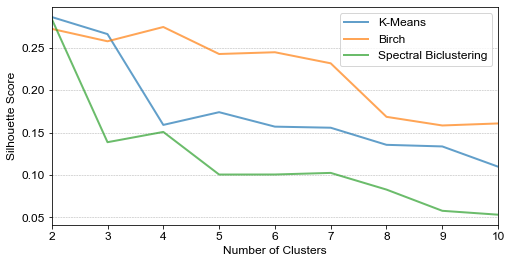

In [205]:
plt.rc('font', family='arial', size=12)
cluster_validation.iloc[:,:3].plot(kind='line',linewidth=2,
                                   alpha=0.7,rot=1,figsize=(8,4),legend=True)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
#plt.yticks(np.arange(0,10000,2000))
plt.xticks(np.arange(0,9,1),np.arange(2,11,1))
plt.grid(axis="y",linestyle='--',linewidth=0.5)
plt.show()

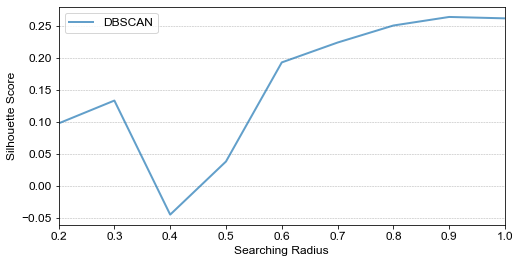

In [206]:
plt.rc('font', family='arial', size=12)
cluster_validation.iloc[:,3].plot(kind='line',linewidth=2,alpha=0.7,rot=1,figsize=(8,4),legend=True)
plt.xlabel('Searching Radius')
plt.ylabel('Silhouette Score')
#plt.yticks(np.arange(0,10000,2000))
plt.xticks(np.arange(0,9,1),['0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0'])
plt.grid(axis="y",linestyle='--',linewidth=0.5)
plt.show()

In [234]:
cluster = SpectralBiclustering(n_clusters=4,random_state=11).fit(X)
print(silhouette_score(X, cluster.row_labels_))
OD = A
OD['label'] = cluster.row_labels_
OD['label'] = OD['label'].replace({0:'Class 1',
                              1:'Class 2',
                              2:'Class 3',
                              3:'Class 4'})
group_stations = OD.groupby('label')
print(group_stations.size())

0.12366666335149176
label
Class 1     86
Class 2    267
Class 3    214
Class 4    365
dtype: int64


In [235]:
## save clustered data
#OD.to_csv('data/cluster_result_spectral_final.csv')

In [237]:
_pickup = group_stations.mean().iloc[:, [i for i in range(1,1+48,2)]].T
_return = group_stations.mean().iloc[:, [i for i in range(2,1+48,2)]].T

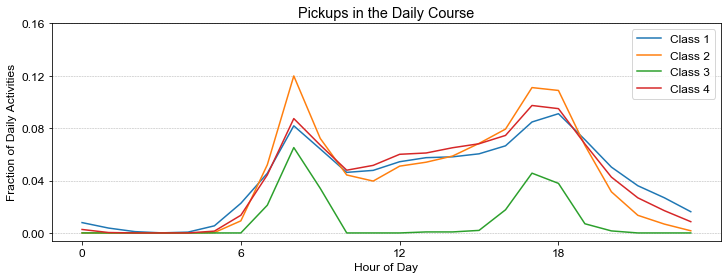

In [238]:
plt.figure(figsize=(12,4))
plt.rc('font', family='arial', size=12)
plt.plot(_pickup, label=True)
plt.title('Pickups in the Daily Course')
plt.xlabel('Hour of Day')
plt.ylabel('Fraction of Daily Activities')
plt.legend(labels=_pickup.columns)
plt.yticks(np.arange(0,0.2,0.04))
plt.xticks(np.arange(0,24,6),np.arange(0,24,6))
plt.grid(axis="y",linestyle='--',linewidth=0.5)
plt.show()

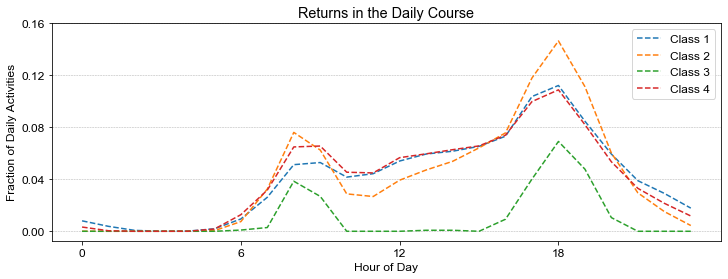

In [239]:
plt.figure(figsize=(12,4))
plt.rc('font', family='arial', size=12)
plt.plot(_return,linestyle='--')
plt.title('Returns in the Daily Course')
plt.xlabel('Hour of Day')
plt.ylabel('Fraction of Daily Activities')
plt.legend(labels=_return.columns)
plt.yticks(np.arange(0,0.2,0.04))
plt.xticks(np.arange(0,24,6),np.arange(0,24,6))
plt.grid(axis="y",linestyle='--',linewidth=0.5)
plt.show()

### Clutering Result Analysis

Four clusters are assigned using K-means algorithm and the number of stations in respective clusters are 261, 64, 394 and 219. 